## BPNet tf-Modisco report

In [1]:
modisco_dir = "/users/avsec/workspace/basepair/data/processed/chipnexus/exp/models/oct-sox-nanog-klf/models/n_dil_layers=9/modisco/valid/new-hparams"

In [2]:
# Parameters
modisco_dir = "Nanog"


In [3]:
from basepair.modisco.results import ModiscoResult
from basepair.config import get_data_dir
from basepair.utils import read_json
from basepair.plot.vdom import vdom_modisco
from kipoi.readers import HDF5Reader
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from plotnine import *

Using TensorFlow backend.


In [4]:
mr = ModiscoResult(f"{modisco_dir}/modisco.h5")
mr.open()

In [5]:
# load the data
modisco_kwargs = read_json(os.path.join(modisco_dir, "kwargs.json"))
d = HDF5Reader(modisco_kwargs['imp_scores'])
d.open()

In [6]:
strand_dist_file = f"{modisco_dir}/strand_distances.h5"
if modisco_kwargs.get("ignore_strand_dist", False) and os.path.exists(strand_dist_file):
    included_samples = HDF5Reader.load(strand_dist_file)['included_samples']
else:
    included_samples = np.ones(d.f['inputs'].shape[:1], dtype=bool)
    
if modisco_kwargs.get("filter_npy", None) is not None:
    included_samples = np.load(modisco_kwargs['filter_npy']) * included_samples
    
    
id_hash = pd.DataFrame({"peak_id": d.f['/metadata/interval_from_task'][:][included_samples], 
                        "example_idx": np.arange(d.f['/metadata/interval_from_task'][included_samples].shape[0])})
tasks = list(d.f["targets"]["profile"].keys())

In [7]:
# get all seqlet instances
dfp = mr.seqlet_df_instances().rename(columns=dict(seqname="example_idx"))
dfp = pd.merge(dfp, id_hash, on="example_idx")

TF-MoDISco is using the TensorFlow backend.


In [8]:
# row = example_idx
total_counts = pd.DataFrame({task: d.f[f"/targets/profile/{task}"][:][included_samples].sum(axis=-1).sum(axis=-1)
          for task in tasks
         })

In [9]:
len(mr.patterns())

30

In [10]:
# total number of seqlets
len(dfp)

21749

In [11]:
# Number of metaclusters
len(mr.metaclusters())

1

### Number of seqlets per pattern

In [12]:
mc_stat = mr.metacluster_stats()

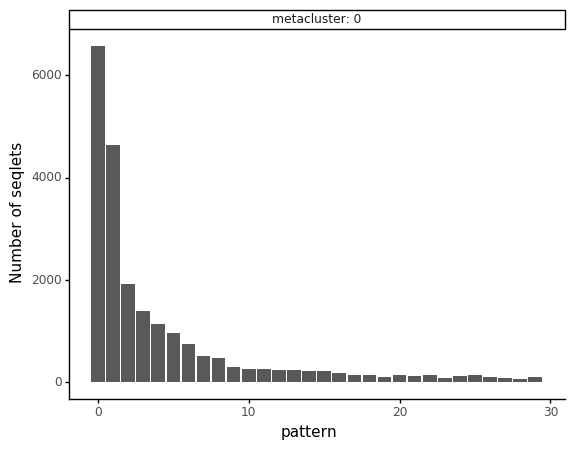

<ggplot: (-9223363270911688255)>

In [13]:
ggplot(aes(x="pattern", y='n'), mc_stat) + geom_bar(stat='identity') + \
    facet_wrap("~metacluster", ncol=4, labeller='label_both') + \
    ylab("Number of seqlets") + theme_classic()

### Zoom-into the 500 seqlet range

In [14]:
ggplot(aes(x="pattern", y='n'), mc_stat) + geom_bar(stat='identity') + \
    facet_wrap("~metacluster", ncol=4, labeller='label_both') + \
    ylab("Number of seqlets") + theme_classic() + coord_cartesian(ylim=[0, 500])

<ggplot: (-9223363270914149081)>

## Important tasks per metacluster

/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)
/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


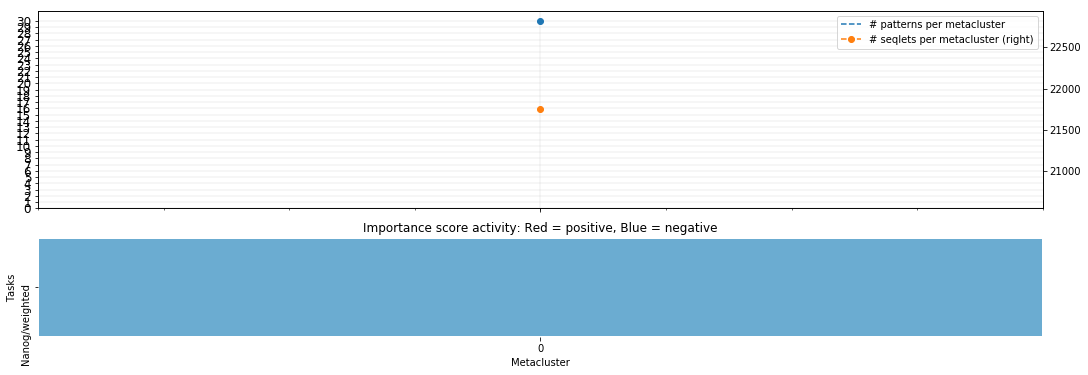

In [15]:
mcs_grouped = mc_stat.groupby("metacluster").n.agg(["count", "sum"]).reset_index()
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(18,6), 
                       gridspec_kw={'height_ratios': [2,1]})
mcs_grouped.plot("metacluster", "count", 
                 label="# patterns per metacluster", style="o--", 
                 ax=ax[0], 
                 yticks=range(mcs_grouped['count'].max()+1),
                 xticks=range(38),
                 fontsize='large',
                 xlim=(-.5, len(mr.metaclusters()) - .5 ))
mcs_grouped.plot("metacluster", "sum", 
                 label="# seqlets per metacluster", 
                 style="o--", ax=ax[0], secondary_y=True)
ax[0].grid(linewidth=0.2)
mr.plot_metacluster_activity(ax[1], cbar=False)
ax[1].set_title("Importance score activity: Red = positive, Blue = negative");

In [16]:
vdom_modisco(mr, "plots", total_counts, dfp, is_open=True, trim_frac=0.08, letter_width=0.15, height=0.5)

<div><details id="metacluster_0" open><summary><b>metacluster_0</b>, # patterns: 30, # seqlets: 21749, important for: <b>Nanog</b></summary><ul><li><details id="metacluster_0/pattern_0"><summary>pattern_0: # seqlets: 6568<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAABZCAYAAAB7Ymt4AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvOIA7rQAAF7hJREFUeJztnXl8VNXd/9/3zp6FkJCVLZAQICEYNpciFFERgbo8j7al2j4KLhWrferyUJ%2Bnrfq41NZ9abWPv1qpotQWrRsVRaS4AMougUAW1kD2lcxMZubOPb8/TphMFoYEkhDqeb9e9zV37j33bHM/95zz/Z5zRxNCCBQKRafopzsDCkV/RglEoYiAEohCEQElEIUiAkogCkUElEAUiggogSgUEVACUSgioASiUERACeQYmta1LTX1dOdU0YdoaqpJC5rW9bCqyr4xqBZEoYiA9XRnoNfpTsugULRDtSAKRQSUQBSKCCiBRMLhkFs4KSmnJy%2BK08K//hikO7S3Th0bvyir1TeWf/0WpP0T/1iLoFoGRRf45vlBwq1aJyr6mdqCdNVyl5IC5eW9m5czHCWQroQ906pIOT17jH/9LpZCcQoogSgUEVACUSgioATyr4iy3PUYapDelbBnehV1p8yKNqgWRKGIgPKkKyRCwMHlUPwieI9AXA5k3w2J557unJ1WVBerK2HP9Co6UZlNAz7/HpR/BIa79bjFBeN%2BAbm/6P089lOUQLoSth9WkSlMntnwDACzMmeRm5x7/MAnKvPWe6DwOQh6Op6zRMH5r8PQK04xx2cmqot1hrLwnYX8efufsepWpu6eytoFa08uoqa9UPgsBL3yu6bLlsPwAAJMPxwt6rF8n2kogZyh5FfmA2CYBkW1p3AD7/wtmAG5b4mCYVdB6kVQ%2BncoWwWmrwdy2zMEzSAfFH8AwDlDziE5OrnX01RWrN6kF9%2BUsrdub2i/yl2FYRrdz59pwIHXQBigOyB9Pkx9BTKug2%2B/DWPvAhGUWz/gv1b9F5ctu4zvL/8%2B1799fZ%2BkqQTSH6io6FZwT8DDUf9RXrnyFTbcsAGH1cH%2B%2Bv3dT7d6PW1ugbxftz1/1v3yU%2BsfHY01%2B9YAsvw7Knf0SZr9o%2BSKblFcW4zL6mJO1hwSoxKx6lYKawoZlTCqexFVrG0de8TlgKudZ13T4Zr%2BY6AoqSsJ7Zc3lWOYBla9d29h1YL0Jr005aOwphANDV2TP5/X8LKnek/381f1qexeocPged2/vg%2Bp9dbiM3x8sfALyu4qw2l1UlJbcuILTxHVgpwqniNQsQaay8GeACkzICZDnmu/GOmYudXnOyXTcWFNIe6AG5tuA%2BRA/aS6HI275ac1GuLzTjo/fUFBVQFOm5NxSeOIc8ahazoF1QWMSRzTq%2BkqgZwswWbYdDvsWwq6FYI%2B0O2ACckXwHkvd%2Byy9BDbyrdh1a24bC48AQ9DYoecnECaW8Y%2BmgYxmT2byR5mV9UuDNPAolsAcPvd5Ffmc%2BXYK3s1XdXFOhnMIHwyG/a/BmYzGE0gAhB0yz59%2BSrYenevJb%2BrahfpA9PxBrz4g34yEzLZV7eve5EYbhCm3DcD4OzfM3u3V2zHE/Bgt9gBsFvsbD6yudfTPXMFcjpfNl3wONRukmKwRMkBbsYNkDwDdKfs1xudeKV7iAMNB8iMzyQoglh1KxnxGdQ31%2BMNeLseia%2B2pcVDtn6OQb2T2R5iS9kW0mLSMEyDhuYGRiWMIr8qv9fTPXMF0lW6aUI9IYYHdj4kp2VYoiDrFpibD%2Bf9ES7%2BJ8xpeap5DvRsui3UeevwGT4y4jNwWBxEWaMYnTCaKFtUGyvPicvRBJql5YsAiyNi8NNNUU0RoweNxh/0A5A1KIuDDQcxj7WCvcSZOwZJSWl78zsccvB77DM8XE9y%2BL3Wfd0GeY%2B0nesUlwNXVYM1pmfTbaGotgiXzcXYxLG4bC4AcpNz0TSNwprCyHOywjH9rfkOCQXpPCz8vRTQMWIyYcT8HipB92nyN1Hvq2f0oNHYdBt2i53Rg0Zj1a0cajhE%2BsD0Xkv7zBVIL1mITkjp2603T/r3oaVP3IZe7K4U1hRiCpNxSeNCx7IGZeHxe7pn6g33jmthHYn6HbDt51JAofOW0yqQPdV7cFldZCdm47K50DWdiakTsepWCqoLelUg/b6LFQxKLRw4ANXV/WBibc1G%2BWmNlWOOPqagqgC3301GfEbo2ODYwRjCYFvFtq5HFN5qtO%2BmWByACNtOLwXVBQgEE1InhHw/2UnZNBvN7Kra1atp90uB%2BHzw/PMwfjw4nTByJIwZA0OGgMsFkyfDli2nKXPeMvmp6RA9ss%2BT316xHYEgLTYtdMxusRPniOvezaI7Wp827edaHZu8eIocOXqElcUrWVWy6uTmirWwo2IHbr%2BbrEFZoWPpcen4g/5et2T1uy7WwYNwwQVyeOHxQFQUNDeDxQKmCXa7FMeKFTBpUh9nTojWqRnCBHt867nGQmiubP1uGwDxZ/V4FnZX7yYlOgXDNEImT2/AS0Z8BsW1xV2PyBbTKgxNl34dixNiM2HwXAg0QvnHtG9BPB5Yuxa2bYOyMlklqamQnQ3Tp0NSkgzX0NzAkCeHMMAxgEAwwAMzH%2BDuqSdn%2Bt5UtglN00iJbh1POq1O4hxxbK/YflJxdpV%2BJZBAAGbOlN0piwWysuDFF2HqVCkMtxs2bYJXXoHZs09DBts8ac1Wy48ZhBXjpEf6GIYHLi%2BG6OE9l7wQlDaWMiltUpv71maxkRGfQX5lPg3NDcQ5404cmX1Q61R23QG%2BGogaIoU9fbk8/nprByMQgIcfhscek8M9j6dtd9flalm1e1CKZOmOpUTZojh852Gu/uvVPPvls9z1rbvQTuIPjXZX7yY9Lh1f0IfNImcPeAIesgZlsatqF0KIk4q3K/QrgSxfDpWVsqVwOODTT9u6MaKjYcYMuZ0Wwvvt6G0HssKAQEPrd2uM9C/0IBXuCjRNY3/9fr468lWoBRFCsLNqJy6bi6LaIqYMnnLiyKwuaYULBuVs3eYKKZBOCJo6c%2BfCunVSGE6nbL3z8uSDbM8e2LhRtvRuNyQmCp5a/xTjksYRY4/hxkk3suCdBaw7tI7zh5/frTL7g34qmiqYMWIGNt2G2y%2BXBDutTjLiM9hRsYNKdyUpMb3j6OxXAlmxAppaDER5ef3wD2U1Ta62C3rkvr9FEJoOKReBez%2B4D0qvei9QWFOIw%2BKgrKmMmX%2Be2eF8rD2WwprCrgkEwJkq84yAo8WQ0Hmf9YVVN4fEERUFq1fDeee1DePzQX4%2BjBgBm45spqypjMXnLyZoBpmbNRchBE9veLrbAimuLcZlc/HpgU9ZtGJRaPauQPDenvdwWB0UVBd8MwRSGdaFT%2B79xWInhzMF3Ptkf8JzADhHiuWij%2BX5d0a23HQ9T2FNIYEIA%2BgmfxMFVQVdjzBunMyr4Ya67ZD%2BvU6DPf3Bf%2BLxgK7DjTd2FAfIFn/yZLn/7JfPYpgG83PnY9EtGAGDy8dczt93/5365noGOge2udZn%2BChvkmb7YXHDQpYqkNNqdE3HMA1e3vZyp/krqCrgghEXdL3c3aBfWbGGDm3dLy09ffmIyLGnrNEE1Rv6NOmdVTvxBDzE2

Metaclusters heatmap


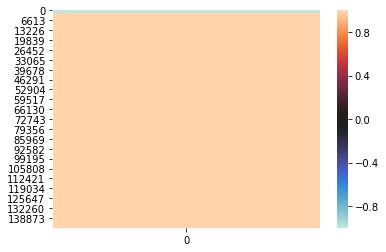

In [17]:
print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(mr.f.f['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(mr.f.f['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0);